In [162]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

In [5]:
os.listdir()

['.ipynb_checkpoints',
 '1_P6vsNdGLGI8viUJK-se3SQ.png',
 'Bingo!.ipynb',
 'images.jpg',
 'Salary Prediction - EDA.ipynb',
 'Salary prediction Modelling.ipynb',
 'salary-prediction-beginner.py.html',
 'salary-prediction-eda.html',
 'salary-prediction-eda_cleared_output_.html',
 'Salary_Prediction_EDA.pptx',
 'Salary_Prediction_Interview_Assignment.docx',
 'test_features.csv',
 'train_features.csv',
 'train_salaries.csv']

### Helper Functions to load, transform and pre-process data from EDA inputs

In [397]:
def data_load(filename):
    '''Read data from csv using pd.read_csv()'''
    return pd.read_csv(str(filename))

def feature_seprator(df):
    '''This fucntions seperates the columns into numerial and object type'''
    categorical_col = []
    numeric_col = []
    default_col = []
    for col in df.columns:
        if df[col].dtype.name == 'object':
            categorical_col.append(col)
        elif df[col].dtype.name == 'int64':
            numeric_col.append(col)
        else:
            default_col.append(col)
    return categorical_col, numeric_col, default_col


def df_merge(df1,df2,colname):
    ''' Merge the data frames e.g. train and traget if any'''
    df = pd.merge(df1,df2,on = str(colname))
    return df


def data_describe(df,col_list):
    ''' The returns the descriptive stats for different column types'''
    return df[col_list].describe().transpose()


def df_duplicate(df):
    ''' Function checks if there are any duplicate rows present in the dataframe'''
    return df.duplicated().sum()


def df_clean(df):
    ''' removes rows that contains salary < 8.5 and/or duplicate jobIds as computed from IQR range for the data'''
    clean_data = df.drop_duplicates(subset='jobId')
    clean_data = clean_data[df.salary > 8.5]
    return clean_data


def oneHot_encoder(df,categorical_col):
    '''This function will encode the categorical variables and combines result with original df dropping previous columns'''
    cat_df = pd.get_dummies(df[categorical_col]) #encoding categorical features
    df.drop(categorical_col, axis = 1, inplace = True) # since we do not need the original features once they are encoded
    return pd.concat([df,cat_df], axis = 1) #combining categorical encoded features with default numeric features 


def df_feature_target(df,target_colname):
    y = (df.pop(target_colname)) #Dropping the salary column from encoded daraframe adn treating it as Target
    X = df #Assigning rest of the features here to X
    return X, y


def train_model(model, feature_df, target_df, mean_mse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df,cv = 5, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
    
def print_summary(model,mean_mse,cv_std):
    print('\n Model : \n', model)
    print('\n Mean square error : \n ', mean_mse)
    print('\n Standard Deviation during CV: \n', cv_std)
    

#Functions defined by Kyle
    
def get_target_df(df, target):
    '''returns target dataframe'''
    return df[target]

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis=1)#,ignore_index=False)


#### Loading Data

In [398]:
train_df = data_load('train_features.csv')
target_df = data_load('train_salaries.csv')
test_df = data_load('test_features.csv')

#### Getting categorical and numeric features

In [399]:
cat_feature, num_feature, default_feature = feature_seprator(train_df)
print('Categorical Feature List: ',cat_feature,'\n',\
      'Numerical Feature List: ',num_feature,'\n',\
      'Other Feature List: ',default_feature)

Categorical Feature List:  ['jobId', 'companyId', 'jobType', 'degree', 'major', 'industry'] 
 Numerical Feature List:  ['yearsExperience', 'milesFromMetropolis'] 
 Other Feature List:  []


#### since 'jobId' is unique for all records, we cannot use it for modeling so we are dropping it from the list of categorical features

In [400]:
cat_feature.pop(0)

'jobId'

In [401]:
cat_feature

['companyId', 'jobType', 'degree', 'major', 'industry']

#### merging the target and training data frame on jobId to get the salaries

In [402]:
df = df_merge(train_df,target_df, colname= 'jobId')

#### We are shuffling our data and reindex it as it can break any underlying false-pattern and can work good for cross validation 

In [403]:
clean_df = df_clean(df)
clean_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [404]:
clean_df.shape

(999995, 9)

#### Encoding categorical features in train and test data set and droping original categorical features 

In [405]:
train_df_encoded = oneHot_encoder(clean_df,cat_feature)
test_df_encoded = oneHot_encoder(test_df,cat_feature)

train_df_encoded.drop('jobId', axis = 1, inplace = True)
test_df_encoded.drop('jobId', axis = 1, inplace = True)

print(train_df_encoded.shape, test_df_encoded.shape)

(999995, 95) (1000000, 94)


#### Getting feature and target dataframe for model inputs 

In [406]:
feature_df, target_df = df_feature_target(train_df_encoded,'salary')
print(feature_df.shape, target_df.shape)

(999995, 94) (999995,)


#### Defining models and hyperparameters for training

In [423]:
models = []
mean_mse = {}
cv_std = {}
res = {}
verbose_lvl = 0

lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(),LinearRegression())
rf = RandomForestRegressor(n_estimators=75,max_depth= 25, min_samples_split=60,max_features= 40, verbose= verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=40,max_depth=5, loss='ls',verbose=verbose_lvl)

models.extend([lr,lr_std_pca,rf,gbm])

print('Initiating Cross Validation')
for model in models:
    train_model(model=model,feature_df=feature_df,target_df=target_df,mean_mse=mean_mse,cv_std=cv_std)
    print_summary(model,mean_mse,cv_std)

Initiating Cross Validation

 Model : 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

 Mean square error : 
  {LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False): 384.4438059455207}

 Standard Deviation during CV: 
 {LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False): 1.7663664008242226}

 Model : 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

 Mean square error : 
  {LinearRegression(copy_X=True, fit_intercept=True,

In [424]:
#choose model with lowest mse
model = min(mean_mse, key=mean_mse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)


Predictions calculated using model with lowest MSE:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=60, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [426]:
model.fit(feature_df, target_df)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=40, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=60, min_weight_fraction_leaf=0.0,
                      n_estimators=75, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [430]:
model.feature_importances_

array([0.18097353, 0.12889277, 0.00063316, 0.00064848, 0.00063558,
       0.00066397, 0.00066895, 0.00066136, 0.00065424, 0.00065854,
       0.00067758, 0.00066185, 0.00065213, 0.00063136, 0.00066872,
       0.00064922, 0.00065143, 0.00066962, 0.0006362 , 0.00066726,
       0.00066174, 0.00062655, 0.00065253, 0.00063753, 0.0006162 ,
       0.00067066, 0.00067001, 0.00064961, 0.00067239, 0.00064744,
       0.0006634 , 0.00068134, 0.00067401, 0.00067118, 0.00063945,
       0.00066283, 0.00066273, 0.00065164, 0.00064617, 0.00063588,
       0.0006894 , 0.00065721, 0.00066218, 0.00065884, 0.00065908,
       0.00065638, 0.00065149, 0.00064497, 0.00064339, 0.00065471,
       0.00064272, 0.00061916, 0.00067327, 0.00065707, 0.00064431,
       0.00063482, 0.0006614 , 0.00065399, 0.00065528, 0.00064791,
       0.00063687, 0.00068201, 0.00064771, 0.00064067, 0.00064875,
       0.04728928, 0.01382292, 0.01257106, 0.18776957, 0.07281564,
       0.01846538, 0.03822256, 0.00922547, 0.00323883, 0.00752

yearsExperience        0.180974
milesFromMetropolis    0.128893
companyId_COMP0        0.000633
companyId_COMP1        0.000648
companyId_COMP10       0.000636
                         ...   
industry_FINANCE       0.020481
industry_HEALTH        0.005171
industry_OIL           0.020676
industry_SERVICE       0.016328
industry_WEB           0.007146
Length: 94, dtype: float64


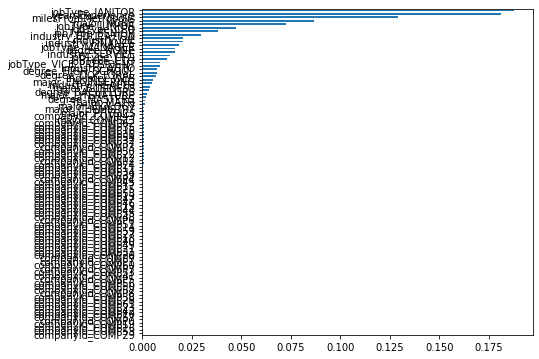

In [432]:
feature_importances = pd.Series(model.feature_importances_, index=feature_df.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(7,6))

degree                 0.036690
companyId              0.041207
major                  0.103355
industry               0.108700
milesFromMetropolis    0.128893
yearsExperience        0.180974
jobType                0.400182
dtype: float64


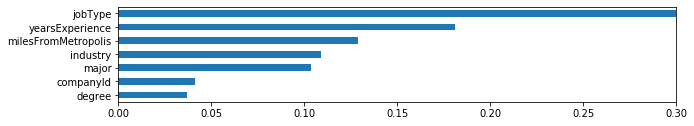

In [434]:
# Create function to combine feature importances
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.1, width=10, summarized_columns=None):  
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i )
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            feature_dict[col_name] = sum_value
    results = pd.Series(feature_dict, index=feature_dict.keys())
    results.sort_values(inplace=True)
    print(results)
    results.plot(kind='barh', figsize=(width, len(results)/4), xlim=(0, .30))
 
# Create combined feature importances
graph_feature_importances(model, feature_df.columns, summarized_columns=cat_feature)

In [441]:
clean_df = df_clean(df)
clean_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


#### shuffling jobType column 

In [446]:
clean_df['jobType'] = np.random.permutation(clean_df['jobType'].values)
clean_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,JANITOR,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,VICE_PRESIDENT,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,MANAGER,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,JANITOR,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,CFO,BACHELORS,PHYSICS,FINANCE,8,16,163


#### encoding it again 

In [447]:
train_df_encoded_1 = oneHot_encoder(clean_df,cat_feature)
#test_df_encoded = oneHot_encoder(test_df,cat_feature)

train_df_encoded_1.drop('jobId', axis = 1, inplace = True)
#test_df_encoded.drop('jobId', axis = 1, inplace = True)

print(train_df_encoded_1.shape) #test_df_encoded.shape)

(999995, 95)


In [449]:
feature_df_1, target_df_1 = df_feature_target(train_df_encoded_1,'salary')
print(feature_df_1.shape, target_df_1.shape)

(999995, 94) (999995,)


In [451]:
mean_mse_1=[]
cv_std_1= []
train_model(model=model,feature_df=feature_df_1,target_df=target_df_1,mean_mse= mean_mse_1,cv_std=cv_std_1)
print_summary(model,mean_mse_1,cv_std_1)

TypeError: list indices must be integers or slices, not RandomForestRegressor

In [448]:
train_df_encoded_1.head()

,yearsExperience,milesFromMetropolis,salary,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [419]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':np.arange(70,80,5).tolist(),
          'max_features':np.arange(40,70,15).tolist()}

In [420]:
#making models with Hyperparameter sets
model1 = GridSearchCV(model, param_grid=params)

In [421]:
model1

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=25,
                                             max_features=30,
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=60,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=80, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [422]:
#train model on entire dataset
print("Model training initiated...")
model1.fit(feature_df, target_df)

#The best hyper parameters set
print("Best Hyper Parameters:\n",model1.best_params_)

#Prediction
print("Prediction as per best hyperparameters")
prediction=model1.predict(test_df)

Model training initiated...
Best Hyper Parameters:
 {'max_features': 40, 'n_estimators': 75}
Prediction as per best hyperparameters


ValueError: could not convert string to float: 'JOB1362685407687'